<a href="https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/notebooks/W266Multi%2BBinary_CK_T5_12_01__NoEmpath_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## T5 References

https://huggingface.co/docs/transformers/model_doc/t5

https://arxiv.org/pdf/1910.10683.pdf

https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb

https://towardsdatascience.com/data-to-text-generation-with-t5-building-a-simple-yet-advanced-nlg-model-b5cce5a6df45

https://colab.research.google.com/github/datasci-w266/2022-fall-main/blob/master/materials/lesson_notebooks/lesson_6_Machine_Translation.ipynb

http://seekinginference.com/applied_nlp/t5-class.html
http://seekinginference.com/NLP/T5_classification



#Initial Set up 

In this notebook 
a ) I am using data from GCS, from courtney which is cleaned for age and other additional columns , 
b) I am also removing AGE from the model and lower string transformations
c) cleaning up the notebook for only model as of now

In [27]:
# Google collab premium utilities status check
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Dec  2 15:12:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    53W / 400W |   1234MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
# imports
import sys
import csv
from enum import Enum

#import unidecode 
#import unicodedata
import pandas as pd
import io
from io import BytesIO
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import textwrap
import re
import time
import random
import datetime

In [29]:
!pip install -q sentencepiece
!pip install -q transformers
!pip install -q optuna

In [31]:

import os, re
import time
import numpy as np
import pandas as pd

import io
from io import BytesIO
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,recall_score,matthews_corrcoef

import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler



In [32]:
SEED = 15
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [33]:
torch.cuda.amp.autocast(enabled=True)

In [34]:
torch.backends.cudnn.deterministic = True

# tell pytorch to use cuda
device = torch.device("cuda")

In [35]:
#imports and installs for feature engineering
!pip install empath
from empath import Empath
lexicon = Empath()
# Import module
!pip install NRCLex
from nrclex import NRCLex
import nltk
nltk.download('punkt')
import collections
from collections import Counter
import spacy
nlp =spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
# To work from gcloud, use this:

# Upload Google Cloud service account key to enable authentication ( json file )
# Go to https://console.cloud.google.com/:
# Under the Navigation Menu ( upper left 3 horizontal lines) 
# 1. choose IAM & Admin>
# 2. choose Service Accounts>
# 3. Select a Service Account>
# 4. Under the Actions menu ( 3 dots to the right of the service account )>Manage Keys to create your own json credentials file

from google.colab import files
from google.cloud import storage


def upload_gcloud_credentials():
    uploaded = files.upload()


def config_GCloud():
    #Load Google Cloud storage client using service key
    storage_client = storage.Client.from_service_account_json('pacific-castle-360400-a3ca89f64de6.json')
    #Print buckets available
    for bucket in storage_client.list_buckets():
        print(bucket)

    #Assign bucket name being used
    gcloud_bucket_name = '266csffile'

    #Get bucket
    gcloud_bucket = storage_client.get_bucket(gcloud_bucket_name)

    #Show list of files in bucket and list the files
    filename = list(gcloud_bucket.list_blobs(prefix=''))
    for name in filename:
        print(name.name)

    #Increase field size to allow reading in of files
    maxInt = sys.maxsize

    while True:
        # decrease the maxInt value by factor 10 as long as overflow error occurs 
        try:
            csv.field_size_limit(maxInt)
            break
        except OverflowError:
            maxInt = int(maxInt/10)

 
    return gcloud_bucket, gcloud_bucket_name


In [37]:
upload_gcloud_credentials()

Saving pacific-castle-360400-a3ca89f64de6.json to pacific-castle-360400-a3ca89f64de6 (1).json


In [38]:
bucket, bucket_name = config_GCloud()

<Bucket: 266csffile>
<Bucket: w266liwc>
dev_is_I_data.parquet
dev_is_I_labels.parquet
dev_is_J_data.parquet
dev_is_J_labels.parquet
dev_is_S_data.parquet
dev_is_S_labels.parquet
dev_is_T_data.parquet
dev_is_T_labels.parquet
dev_mbti_data.parquet
dev_mbti_labels.parquet
mrc2.dct.textClipping
old_files/
old_files/dev_mbti_data.csv
old_files/dev_mbti_data.parquet
old_files/dev_mbti_labels.csv
old_files/test_mbti_data.csv
old_files/test_mbti_data.parquet
old_files/test_mbti_labels.csv
old_files/train_gen_pop_mbti_data.csv
old_files/train_gen_pop_mbti_data.parquet
old_files/train_gen_pop_mbti_labels.csv
old_files/train_mbti_data.csv
old_files/train_mbti_data.parquet
old_files/train_mbti_labels.csv
old_files/train_over_sampled_mbti_data.csv
old_files/train_over_sampled_mbti_data.parquet
old_files/train_over_sampled_mbti_labels.csv
old_files/train_under_sampled_mbti_data.csv
old_files/train_under_sampled_mbti_data.parquet
old_files/train_under_sampled_mbti_labels.csv
t5_dev_uniform.parquet
t5

In [39]:
# setup google drive access for checkpoint file

from google.colab import drive
drive.mount('/content/drive')

!ls -lrt "/content/drive/My Drive"
!ls -lrt "/content/drive/My Drive/W266/MBTI/model_checkpoints"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 20
drwx------ 2 root root 4096 Jan 24  2022 'Colab Notebooks'
drwx------ 2 root root 4096 Oct 21 00:00  content
drwx------ 2 root root 4096 Oct 21 17:29  ULondon
drwx------ 2 root root 4096 Oct 21 17:31  MIDS
drwx------ 3 root root 4096 Nov 22 16:09  W266
total 1344494
-rw------- 1 root root 445902488 Nov 22 22:37 bert_multibinary_1122_noemote.hdf5
-rw------- 1 root root 445902488 Nov 28 19:50 bert_multibinary_1120.hdf5
-rw------- 1 root root 242086395 Dec  2 03:22 t5-classification.pt
-rw------- 1 root root      1473 Dec  2 03:22 config.json
-rw------- 1 root root 242070267 Dec  2 03:22 pytorch_model.bin
-rw------- 1 root root      2374 Dec  2 03:22 tokenizer_config.json
-rw------- 1 root root    791656 Dec  2 03:22 spiece.model
-rw------- 1 root root      2201 Dec  2 03:22 special_tokens_map.json


In [40]:
t5_model_name='t5-small'

In [41]:
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name )

In [42]:
print(t5_tokenizer.eos_token_id)
print(t5_tokenizer.bos_token_id)
print(t5_tokenizer.unk_token_id)
print(t5_tokenizer.pad_token_id)

1
None
2
0


# Data Prep

In [43]:
max_length = 512
batch_size = 16

In [44]:
def read_parquet_google_cloud(file):
    '''This function reads a file from the google cloud storage bucket. Input
    parameters include the filename, encoding and CSV file separators.'''

    #Load Google Cloud storage client using service key

    blob = bucket.blob(file)
    read_back = bucket.blob(file)
    string_read_back = read_back.download_as_string()
    new_df = pd.read_parquet(io.BytesIO(string_read_back))

    return new_df

In [45]:
def write_parquet_google_cloud( df, filename):

    bucket, bucket_name = config_GCloud()

    blob = bucket.blob( filename )
    blob.upload_from_string(df.to_parquet(), 'application/octet-stream')


In [46]:


# for T5
separator_token = " </s>"
prefix_text = 'multilabel classification: '

# for Bert
# separator_token = " [SEP] "
# prefix_text = ''


class Features(Enum):
    all_features = 1
    no_username = 2
    no_emotions = 3
    no_lexicon = 4
    no_postags = 5

def combine_no_username(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = prefix_text + df['Age'].astype(str)+ separator_token + df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"lexical categories: "+df['lexicon'].astype(str)+  separator_token +"emotion scores: "+df['emotions'].astype(str)+ separator_token + "pos tags: "+df['postags'].astype(str)+ separator_token+ df['message'].astype(str)+ separator_token
    return df

def combine_no_emotion(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = prefix_text +  df['Username'].astype(str)+ separator_token + df['Age'].astype(str)+ separator_token +df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"lexical categories: "+df['lexicon'].astype(str)+  separator_token + "pos tags: "+df['postags'].astype(str)+  separator_token + df['message'].astype(str)+ separator_token
    return df

def combine_no_lexical(df):
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = prefix_text +  df['Username'].astype(str)+ separator_token + df['Age'].astype(str)+ separator_token +df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"emotion scores: "+df['emotions'].astype(str)+ separator_token + "pos tags: "+df['postags'].astype(str)+ separator_token + df['message'].astype(str)+ separator_token
    return df

def combine_no_pos(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
 
    df['combined'] = prefix_text +  df['Username'].astype(str)+ separator_token + df['Age'].astype(str)+ separator_token +df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"lexical categories: "+df['lexicon'].astype(str)+ separator_token +"emotion scores: "+df['emotions'].astype(str)+ separator_token+ df['message'].astype(str)+ separator_token
    return df

def combine_all(df):
    df['lexicon'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in lexicon.analyze(x).items() if value > 0))
    df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
    df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
 
    df['combined'] = prefix_text +  df['Username'].astype(str)+ separator_token + df['Age'].astype(str)+ separator_token +df['Posts'].astype(str)+ separator_token +df['Occupation'].astype(str)+ separator_token +"lexical categories: "+df['lexicon'].astype(str)+  separator_token +"emotion scores: "+df['emotions'].astype(str)+ separator_token + "pos tags: "+df['postags'].astype(str)+ separator_token + df['message'].astype(str)+ separator_token
    return df



def add_features( df, features_to_include ):

    if features_to_include is Features.all_features:
        return combine_all(df)

    elif features_to_include is Features.no_username:
        return combine_no_username(df)

    elif features_to_include is Features.no_emotions:
        return combine_no_emotion(df)

    elif features_to_include is Features.no_lexicon:
        return combine_no_lexical(df)

    else: # features_to_include is Features.no_postags:
        return combine_no_pos(df)


 

    

In [ ]:
train_mbti_data = read_parquet_google_cloud('train_uniform_mbti_data.parquet')
train_mbti_labels = read_parquet_google_cloud('train_uniform_mbti_labels.parquet')

#remove gender from the train data set ( rather than dealing with de-biasing )
train_mbti_data = train_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

dev_mbti_data = read_parquet_google_cloud('dev_mbti_data.parquet')
dev_mbti_labels = read_parquet_google_cloud('dev_mbti_labels.parquet')

#remove gender from the dev data set ( rather than dealing with de-biasing )
dev_mbti_data = dev_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

test_mbti_data = read_parquet_google_cloud('test_mbti_data.parquet')
test_mbti_labels = read_parquet_google_cloud('test_mbti_labels.parquet')

#remove gender from the dev data set ( rather than dealing with de-biasing )
test_mbti_data = test_mbti_data[['Username','Age','Posts','Occupation','message','is_I','is_S','is_T','is_J']]

In [47]:
# define sample sizes for each run

# start with small dimensions to try out the model
n_train_samples = 120000
n_test_samples = 93106
n_dev_samples = 20000

In [ ]:
# add features, but only to the number of samples dictated by the sample size defined above.

train_mbti_short_df = train_mbti_data[ 0 : n_train_samples ]
test_mbti_short_df = test_mbti_data[ 0 : n_test_samples ]
dev_mbti_short_df = dev_mbti_data[ 0: n_dev_samples ]

train_mbti_short_labels_df = train_mbti_labels[0: n_train_samples]
test_mbti_short_labels_df = test_mbti_labels[0: n_test_samples]
dev_mbti_short_labels_df = dev_mbti_labels[0: n_dev_samples]


train_df = add_features(train_mbti_short_df, Features.no_lexicon)
test_df = add_features(test_mbti_short_df, Features.no_lexicon)
dev_df = add_features( dev_mbti_short_df, Features.no_lexicon)


<ipython-input-19-465bc000b9c4>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['emotions'] = df['message'].apply(lambda x: ', '.join(f'{key} {str(value)}' for key, value in NRCLex(x).raw_emotion_scores.items() if value > 0))
<ipython-input-19-465bc000b9c4>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['postags'] =  df['message'].apply(lambda x: ', '.join(f'{key.lower()} {str(value)}' for key, value in Counter((token.pos_ for token in nlp(x))).items()))
<ipython-input-19-465bc000b9c4>:36: Settin

In [ ]:
train_df.head()

,Username,Age,Posts,Occupation,message,is_I,is_S,is_T,is_J,emotions,postags,combined
0,oneandonly,37.0,109,None,i do not think i am at all. but the question...,True,False,False,True,"negative 2, positive 2, anticipation 1","space 1, pron 18, aux 17, part 8, verb 19, adv...",multilabel classification: oneandonly </s>37.0...
1,thalassa,45.0,25183,tree people,YYY0 of the longest threads on this site con...,True,True,False,False,"negative 2, anger 1, anticipation 1, joy 1, po...","space 2, propn 2, adp 7, det 3, adj 7, noun 6,...",multilabel classification: thalassa </s>45.0 <...
2,lady_x,46.0,18233,photographer,XXXX seems right..i would guess t/f were balan...,False,False,False,False,"surprise 1, positive 3, joy 1, trust 1","noun 6, verb 5, adj 3, punct 6, pron 5, aux 3,...",multilabel classification: lady_x </s>46.0 </s...
3,eagle,31.0,733,student,i noticed. it is hard to care over such a gr...,True,True,True,True,"fear 2, negative 2, trust 3, positive 2, joy 1...","space 1, pron 9, verb 7, punct 8, aux 6, adj 7...",multilabel classification: eagle </s>31.0 </s>...
4,ayoitsstepho,31.0,4838,painter,:hug:,True,True,False,False,"joy 1, positive 1, trust 1","punct 2, noun 1",multilabel classification: ayoitsstepho </s>31...


In [ ]:
# write these out to files

write_parquet_google_cloud( train_df, 't5_train_uniform.parquet')
write_parquet_google_cloud( test_df, 't5_test_uniform.parquet')
write_parquet_google_cloud( dev_df, 't5_dev_uniform.parquet')

<Bucket: 266csffile>
<Bucket: w266liwc>
dev_is_I_data.parquet
dev_is_I_labels.parquet
dev_is_J_data.parquet
dev_is_J_labels.parquet
dev_is_S_data.parquet
dev_is_S_labels.parquet
dev_is_T_data.parquet
dev_is_T_labels.parquet
dev_mbti_data.parquet
dev_mbti_labels.parquet
mrc2.dct.textClipping
old_files/
old_files/dev_mbti_data.csv
old_files/dev_mbti_data.parquet
old_files/dev_mbti_labels.csv
old_files/test_mbti_data.csv
old_files/test_mbti_data.parquet
old_files/test_mbti_labels.csv
old_files/train_gen_pop_mbti_data.csv
old_files/train_gen_pop_mbti_data.parquet
old_files/train_gen_pop_mbti_labels.csv
old_files/train_mbti_data.csv
old_files/train_mbti_data.parquet
old_files/train_mbti_labels.csv
old_files/train_over_sampled_mbti_data.csv
old_files/train_over_sampled_mbti_data.parquet
old_files/train_over_sampled_mbti_labels.csv
old_files/train_under_sampled_mbti_data.csv
old_files/train_under_sampled_mbti_data.parquet
old_files/train_under_sampled_mbti_labels.csv
t5_dev_uniform.parquet
t5

In [48]:
train_df = read_parquet_google_cloud('t5_train_uniform.parquet')
test_df = read_parquet_google_cloud('t5_test_uniform.parquet')
dev_df = read_parquet_google_cloud('t5_dev_uniform.parquet')

train_mbti_labels = read_parquet_google_cloud('train_uniform_mbti_labels.parquet')
dev_mbti_labels = read_parquet_google_cloud('dev_mbti_labels.parquet')
test_mbti_labels = read_parquet_google_cloud('test_mbti_labels.parquet')

train_mbti_short_labels_df = train_mbti_labels[0: n_train_samples]
test_mbti_short_labels_df = test_mbti_labels[0: n_test_samples]
dev_mbti_short_labels_df = dev_mbti_labels[0: n_dev_samples]


In [49]:
# create pandas dataframe with the correct format of "prefix" + "input_text" and "target_text"


def create_T5_df( input_df, labels_df, n_rows ):
    input_text_list = input_df['combined']
    target_text_list = labels_df['MBTI Type']

    combined_dict = { 'input_text': input_text_list, 'target_text': target_text_list}

    return pd.DataFrame(combined_dict)


In [50]:
# create custom dfs with the 3 columns necessary for creating prefix, input text and target text 

t5_train_df = create_T5_df(train_df, train_mbti_short_labels_df, n_train_samples )
t5_test_df = create_T5_df(test_df, test_mbti_short_labels_df, n_test_samples )
t5_dev_df = create_T5_df(dev_df, dev_mbti_short_labels_df, n_dev_samples )

In [ ]:
t5_train_df.head()

In [52]:
def preprocess_data( input_text, target_text, tokenizer, max_length=512 ):

    input_ids = []
    input_attention_masks = []

    target_ids = []

    input_encodings = tokenizer.encode_plus(input_text,
                                            add_special_tokens=True, # add tokens relative to model
                                            truncation=True,  # truncate longer inputs
                                            max_length=max_length,  # set max_length
                                            padding = 'max_length',  # add padding
                                            return_attention_mask=True,  # create attn masks
                                            return_tensors='pt')  #return pytorch tensors

    # Extract input ids and attention masks, add to corresponding lists
    input_ids.append(input_encodings["input_ids"])
    input_attention_masks.append(input_encodings["attention_mask"])

    target_ids.append(tokenizer(target_text + " </s>"))

    return [input_ids,input_attention_masks], [target_ids]


In [53]:
# figure out the max_length for the targets after tokenizing
target_text_list = [ label + " </s>" for label in train_mbti_short_labels_df['MBTI Type']]
target_tokens_length = []

for i in range( 0, len(target_text_list)):
    target_tokens_length.append(len(t5_tokenizer.tokenize(target_text_list[i])))

target_len_df = pd.DataFrame({'len_target_tokens': target_tokens_length})

mean_len = target_len_df['len_target_tokens'].mean()
max_len = target_len_df['len_target_tokens'].max()

print( "Mean target tokens len:", mean_len, "Max target tokens len:", max_len )

max_target_length = max_len


Mean target tokens len: 3.74945 Max target tokens len: 4


In [54]:
def tokenize_textlist( text_list, tokenizer, max_length = 512 ):

    token_ids = []
    token_attention_masks = []

    for text in text_list:
        token_encodings = tokenizer.encode_plus(text,
                                            add_special_tokens=True, # add tokens relative to model
                                            truncation=True,  # truncate longer inputs
                                            max_length=max_length,  # set max_length
                                            padding = 'max_length',  # add padding
                                            return_attention_mask=True,  # create attn masks
                                            return_tensors='pt')  #return pytorch tensors

        token_ids.append(token_encodings['input_ids'])
        token_attention_masks.append(token_encodings['attention_mask'])

    return torch.cat(token_ids, dim=0), torch.cat(token_attention_masks, dim=0)



In [55]:
# tokenize train set

train_input_ids, train_attention_masks = tokenize_textlist( t5_train_df['input_text'], t5_tokenizer, 512 )
train_target_ids, train_target_attention_masks = tokenize_textlist( t5_train_df['target_text'], t5_tokenizer, max_target_length)

# create a dataset for training
train_dataset = TensorDataset( train_input_ids, train_attention_masks, train_target_ids, train_target_attention_masks )

# create a dataloader for training
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = False)


/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [56]:
# tokenize test set

test_input_ids, test_attention_masks = tokenize_textlist( t5_test_df['input_text'], t5_tokenizer, 512 )
test_target_ids, test_target_attention_masks = tokenize_textlist( t5_test_df['target_text'], t5_tokenizer, max_target_length)

# create a dataset for test
test_dataset = TensorDataset( test_input_ids, test_attention_masks, test_target_ids, test_target_attention_masks )

# create a dataloader for test
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = False)



/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [57]:
# tokenize dev set

dev_input_ids, dev_attention_masks = tokenize_textlist( t5_dev_df['input_text'], t5_tokenizer, 512 )
dev_target_ids, dev_target_attention_masks = tokenize_textlist( t5_dev_df['target_text'], t5_tokenizer, max_target_length)

# create a dataset for dev
dev_dataset = TensorDataset( dev_input_ids, dev_attention_masks, dev_target_ids, dev_target_attention_masks )

# create a dataloader for dev
dev_dataloader = DataLoader(dev_dataset, batch_size = 16, shuffle = False)



# Create Model and Stages for it

the following code is largely cut and paste from http://seekinginference.com/applied_nlp/t5-class.html


In [58]:
def train(model, dataloader, optimizer):

    # capture time
    total_t0 = time.time()

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')

    # reset total loss for epoch
    train_total_loss = 0
    total_train_f1 = 0

    # put model into traning mode
    model.train()

    # for each batch of training data...
    for step, batch in enumerate(dataloader):

        # progress update every 40 batches.
        if step % 40 == 0 and not step == 0:

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

        # Unpack this training batch from our dataloader:
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains 4 pytorch tensors:
        #   [0]: input tokens
        #   [1]: attention masks
        #   [2]: target tokens
        #   [3]: target attenion masks
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_target_ids = batch[2].cuda()
        b_target_mask = batch[3].cuda()

        # clear previously calculated gradients
        optimizer.zero_grad()

        # runs the forward pass with autocasting.
        with autocast():
            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_target_ids,
                            decoder_attention_mask=b_target_mask)

            loss, prediction_scores = outputs[:2]

            # sum the training loss over all batches for average loss at end
            # loss is a tensor containing a single value
            train_total_loss += loss.item()

        # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
        # Backward passes under autocast are not recommended.
        # Backward ops run in the same dtype autocast chose for corresponding forward ops.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        # update the learning rate
        scheduler.step()

    # calculate the average loss over all of the batches
    avg_train_loss = train_total_loss / len(dataloader)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Train Loss': avg_train_loss
        }
    )

    # training time end
    training_time = format_time(time.time() - total_t0)

    # print result summaries
    print("")
    print("summary results")
    print("epoch | trn loss | trn time ")
    print(f"{epoch+1:5d} | {avg_train_loss:.5f} | {training_time:}")

    return training_stats


def validating(model, dataloader):

    # capture validation time
    total_t0 = time.time()

    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    # put the model in evaluation mode
    model.eval()

    # track variables
    total_valid_loss = 0

    # evaluate data for one epoch
    for batch in dataloader:

        # Unpack this training batch from our dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input tokens
        #   [1]: attention masks
        #   [2]: target tokens
        #   [3]: target attenion masks
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_target_ids = batch[2].cuda()
        b_target_mask = batch[3].cuda()

        # tell pytorch not to bother calculating gradients
        # as its only necessary for training
        with torch.no_grad():

            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_target_ids,
                            decoder_attention_mask=b_target_mask)

            loss, prediction_scores = outputs[:2]

            # sum the training loss over all batches for average loss at end
            # loss is a tensor containing a single value
            total_valid_loss += loss.item()

    # calculate the average loss over all of the batches.
    global avg_val_loss
    avg_val_loss = total_valid_loss / len(dataloader)

    # Record all statistics from this epoch.
    valid_stats.append(
        {
            'Val Loss': avg_val_loss,
            'Val PPL.': np.exp(avg_val_loss)
        }
    )

    # capture end validation time
    training_time = format_time(time.time() - total_t0)

    # print result summaries
    print("")
    print("summary results")
    print("epoch | val loss | val ppl | val time")
    print(f"{epoch+1:5d} | {avg_val_loss:.5f} | {np.exp(avg_val_loss):.3f} | {training_time:}")

    return valid_stats


def testing(model, dataloader):

    print("")
    print("Running Testing...")

    # measure training time
    t0 = time.time()

    # put the model in evaluation mode
    model.eval()

    # track variables
    total_test_loss = 0
    total_test_acc = 0
    total_test_f1 = 0
    predictions = []
    actuals = []

    # evaluate data for one epoch
    for step, batch in enumerate(dataloader):
        # progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader), elapsed))

        # Unpack this training batch from our dataloader:
        # `batch` contains 4 pytorch tensors:
        #   [0]: input tokens
        #   [1]: attention masks
        #   [2]: target tokens
        #   [3]: target attenion masks
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_target_ids = batch[2].cuda()
        b_target_mask = batch[3].cuda()

        # tell pytorch not to bother calculating gradients
        # as its only necessary for training
        with torch.no_grad():

            # forward propagation (evaluate model on training batch)
            outputs = model(input_ids=b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_target_ids,
                            decoder_attention_mask=b_target_mask)

            loss, prediction_scores = outputs[:2]

            total_test_loss += loss.item()

            generated_ids = model.generate(
                    input_ids=b_input_ids,
                    attention_mask=b_input_mask,
                    max_length=max_target_length
                    )

            preds = [t5_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [t5_tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in b_target_ids]

            total_test_acc += accuracy_score(target, preds)
            total_test_f1 += f1_score(preds, target,
                                       average='weighted',
                                       labels=np.unique(preds))
            predictions.extend(preds)
            actuals.extend(target)

    # calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(dataloader)

    avg_test_acc = total_test_acc / len(test_dataloader)

    avg_test_f1 = total_test_f1 / len(test_dataloader)

    # Record all statistics from this epoch.
    test_stats.append(
        {
            'Test Loss': avg_test_loss,
            'Test PPL.': np.exp(avg_test_loss),
            'Test Acc.': avg_test_acc,
            'Test F1': avg_test_f1
        }
    )
    global df2
    temp_data = pd.DataFrame({'predicted': predictions, 'actual': actuals})
    df2 = df2.append(temp_data)

    return test_stats
    

# time function
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Training Preparation


In [111]:
# instantiate model T5 transformer with a language modeling head on top
model = T5ForConditionalGeneration.from_pretrained(t5_model_name).cuda()  # to GPU

In [112]:
# Adam w/ Weight Decay Fix
# set to optimizer_grouped_parameters or model.parameters()
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 3e-5
                  )

# epochs
epochs = 4

# lr scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# create gradient scaler for mixed precision
scaler = GradScaler()


In [113]:
print( "Length train_dataloader:", len(train_dataloader))
print( "Total steps:", total_steps)

Length train_dataloader: 7500
Total steps: 30000


In [ ]:
# create training result storage
training_stats = []
valid_stats = []
best_valid_loss = float('inf')



# for each epoch
for epoch in range(epochs):
    # train
    train(model, train_dataloader, optimizer)
    # validate
    validating(model, dev_dataloader)
    # check validation loss
    if valid_stats[epoch]['Val Loss'] < best_valid_loss:
        best_valid_loss = valid_stats[epoch]['Val Loss']
        # save best model for use later
        torch.save({'epoch': valid_stats[epoch],
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': valid_stats[epoch]['Val Loss']}, 
                    '/content/drive/My Drive/W266/MBTI/model_checkpoints/t5-classification.pt' )
            
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained('/content/drive/My Drive/W266/MBTI/model_checkpoints/')  # transformers save
        t5_tokenizer.save_pretrained('/content/drive/My Drive/W266/MBTI/model_checkpoints/')  # transformers save


In [117]:
# organize results
pd.set_option('precision', 3)
df_train_stats = pd.DataFrame(data=training_stats)
df_valid_stats = pd.DataFrame(data=valid_stats)
df_stats = pd.concat([df_train_stats, df_valid_stats], axis=1)
df_stats.insert(0, 'Epoch', range(1, len(df_stats)+1))
df_stats = df_stats.set_index('Epoch')
df_stats


,Train Loss,Val Loss,Val PPL.
Epoch,,,
1,0.481,0.139,1.149
2,0.136,0.078,1.081
3,0.089,0.060,1.062
4,0.074,0.055,1.057


In [118]:
def load_model_from_checkpoints( model, optimizer, path_to_checkpoint ):

    # load state from file
    checkpoint = torch.load('/content/drive/My Drive/W266/MBTI/model_checkpoints/t5-classification.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return model, optimizer, epoch, loss

In [ ]:
# alternatively, load model from checkpoint if it has already been trained and saved satisfactorily.

# use this cell if you trained the model in a previous session and are reloading it from a file

# instantiate model T5 transformer with a language modeling head on top
model = T5ForConditionalGeneration.from_pretrained(t5_model_name).cuda()  # to GPU

# Adam w/ Weight Decay Fix
# set to optimizer_grouped_parameters or model.parameters()
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 3e-5
                  )



model, optimizer, epoch, loss = load_model_from_checkpoints( model, optimizer, '/content/drive/My Drive/W266/MBTI/model_checkpoints/t5-classification.pt')



In [119]:
# test the model
df2 = pd.DataFrame({'predicted': [], 'actual': []})
test_stats = []

model, optimizer, epoch, loss = load_model_from_checkpoints( model, optimizer, '/content/drive/My Drive/W266/MBTI/model_checkpoints/t5-classification.pt')


In [120]:
testing( model, test_dataloader )


Running Testing...
  Batch    40  of  5,820.    Elapsed: 0:00:06.
  Batch    80  of  5,820.    Elapsed: 0:00:12.
  Batch   120  of  5,820.    Elapsed: 0:00:18.
  Batch   160  of  5,820.    Elapsed: 0:00:24.
  Batch   200  of  5,820.    Elapsed: 0:00:30.
  Batch   240  of  5,820.    Elapsed: 0:00:36.
  Batch   280  of  5,820.    Elapsed: 0:00:42.
  Batch   320  of  5,820.    Elapsed: 0:00:48.
  Batch   360  of  5,820.    Elapsed: 0:00:55.
  Batch   400  of  5,820.    Elapsed: 0:01:01.
  Batch   440  of  5,820.    Elapsed: 0:01:07.
  Batch   480  of  5,820.    Elapsed: 0:01:13.
  Batch   520  of  5,820.    Elapsed: 0:01:19.
  Batch   560  of  5,820.    Elapsed: 0:01:25.
  Batch   600  of  5,820.    Elapsed: 0:01:31.
  Batch   640  of  5,820.    Elapsed: 0:01:37.
  Batch   680  of  5,820.    Elapsed: 0:01:43.
  Batch   720  of  5,820.    Elapsed: 0:01:49.
  Batch   760  of  5,820.    Elapsed: 0:01:55.
  Batch   800  of  5,820.    Elapsed: 0:02:01.
  Batch   840  of  5,820.    Elapsed: 0:

[{'Test Loss': 0.056949202388161264,
  'Test PPL.': 1.058602034574426,
  'Test Acc.': 0.925805412371134,
  'Test F1': 0.9196260505309629}]

In [121]:
df_test_stats = pd.DataFrame(data=test_stats)
print(df_test_stats)

   Test Loss  Test PPL.  Test Acc.  Test F1
0      0.057      1.059      0.926     0.92


In [122]:
print(df2.head(50))

   predicted actual
0       ENFP   ENFP
1       ENFJ   ENFJ
2       INTP   INTP
3       INTP   INTP
4       ESFJ   ESFJ
5       ENTP   ENTP
6       INFP   INFP
7       INFP   INFP
8       INFP   INFP
9       INFJ   INFJ
10      ENFP   ENFP
11      ESFP   ESFP
12      ISFJ   ISFJ
13      ISTP   ISTP
14      INTJ   INTJ
15      ENFP   ENFP
16      ESTJ   ESTJ
17      INFJ   INFJ
18      INFJ   INFJ
19      ENFP   ENFP
20      ESTJ   ESTJ
21      ESFP   ESFP
22      ENFP   ENFP
23      ESTJ   ESTJ
24      INTP   INTP
25      INTJ   INTJ
26      INTP   INTP
27      ISTP   ISTP
28      ISFP   ISFP
29      INTJ   INTJ
30      ISFP   ISFP
31      ISTP   ISTP
32      ISTJ   INFJ
33      ENFP   ENFP
34      INFJ   ENFJ
35      INTJ   INTJ
36      INFJ   INFJ
37      ENFP   ENFP
38      ESFJ   ESFJ
39      ISTP   ISTP
40      ENFP   ENFP
41      ENTJ   ENTJ
42      ENTP   ENTP
43      INFP   INFP
44      ENTJ   ENTJ
45      ISFP   ISFP
46      ISFP   ISFP
47      INFJ   INFJ
48      INTJ   INTJ


# Results Analysis

In [123]:
# first look at the target labels for the test set
# are there any invalid labels, and if so, are they in the predictions or the input?

target_class_group = t5_test_df.groupby(['target_text']).count()

print( "t5 test target classes:", target_class_group )

predicted_class_group = df2.groupby(['predicted']).count()
actual_class_group = df2.groupby(['actual']).count()

print( "predicted classes:", predicted_class_group )
print( "actual classes:", actual_class_group )


# so the invalid classes are a result of prediction, not invalid inputs

predicted_classes = [ ]

for group in predicted_class_group:
    print( group )


t5 test target classes:              input_text  prediction
target_text                        
ENFJ               2920           0
ENFP              11048           0
ENTJ               4186           0
ENTP               8567           0
ESFJ               2169           0
ESFP               2126           0
ESTJ               2243           0
ESTP               1840           0
INFJ               9275           0
INFP              12497           0
INTJ              12850           0
INTP              12925           0
ISFJ               1061           0
ISFP               3946           0
ISTJ               1877           0
ISTP               3576           0
predicted classes:            actual
predicted        
ENFJ         2914
ENFP        10335
ENTJ         4357
ENTP         8797
ESFJ         2146
ESFP         2141
ESTJ         2243
ESTP         1912
INFJ         8854
INFP        11689
INTJ        12092
INTP        12250
ISFJ         1226
ISFP         3886
ISTJ         2974
IST

In [180]:
# create lists of predicted and actual class types for display

predicted_classes = [ ]
actual_classes = [ ]

print( predicted_class_group )
print( type( predicted_class_group))

for row in predicted_class_group.iterrows():
    print( row[0] )
    predicted_classes.append(row[0])

for row in actual_class_group.iterrows():
    print( row[0] )
    actual_classes.append(row[0])




           actual
predicted        
ENFJ         2914
ENFP        10335
ENTJ         4357
ENTP         8797
ESFJ         2146
ESFP         2141
ESTJ         2243
ESTP         1912
INFJ         8854
INFP        11689
INTJ        12092
INTP        12250
ISFJ         1226
ISFP         3886
ISTJ         2974
ISTP         5290
<class 'pandas.core.frame.DataFrame'>
ENFJ
ENFP
ENTJ
ENTP
ESFJ
ESFP
ESTJ
ESTP
INFJ
INFP
INTJ
INTP
ISFJ
ISFP
ISTJ
ISTP
ENFJ
ENFP
ENTJ
ENTP
ESFJ
ESFP
ESTJ
ESTP
INFJ
INFP
INTJ
INTP
ISFJ
ISFP
ISTJ
ISTP


In [181]:
# check to see if we got any unknown class types, and if so what percentage of the results they account for
unknown_class_count = 0

predicted_values = []
actual_values = []

columns = list(df2)
for i in range( 0, df2.shape[0]):
    if df2.iloc[i][0] not in actual_classes:
        print( "row:", i, "predicted:", df2.iloc[i][0] , "actual:", df2.iloc[i][1])
        unknown_class_count = unknown_class_count + 1
    else:
        predicted_values.append(df2.iloc[i][0])
        actual_values.append( df2.iloc[i][1])

print( "Percentage of predictions outside of class set:", 100*unknown_class_count/ df2.shape[0])


Percentage of predictions outside of class set: 0.0


In [185]:
print( len(actual_classes))

16


### Earlier runs of the t5-small model with just a single epoch were returning some class types that were invalid.  Increasing the training to 4 epochs eliminated this problem.

In [198]:
from sklearn.metrics import confusion_matrix


def document_multimodel_run( model_type,
                            mbti_model,
                            predicted_results,
                            predicted_labels,
                            actual_values,
                            actual_labels ):


 
   #Multiclass classification
  print(classification_report(actual_values, predicted_results))

  cr_multi = classification_report(actual_values, predicted_results)

  cm_multi = confusion_matrix(actual_values, predicted_results)
  cm_multi = cm_multi/cm_multi.sum(axis=1)[:,np.newaxis]

  plt.figure(figsize=(len(predicted_labels),len(actual_labels)))
  sns.heatmap(
      cm_multi, annot=True, annot_kws={"size": 10},
      xticklabels=predicted_labels,
      yticklabels=actual_labels)
  plt.xlabel("Predicted", fontsize=20)
  plt.ylabel("True", fontsize=20)

  

Run the classification and confusion matrix after filtering out invalid predictions.

              precision    recall  f1-score   support

        ENFJ       0.95      0.95      0.95      2920
        ENFP       0.98      0.92      0.95     11048
        ENTJ       0.93      0.96      0.94      4186
        ENTP       0.92      0.94      0.93      8567
        ESFJ       1.00      0.99      0.99      2169
        ESFP       0.98      0.98      0.98      2126
        ESTJ       0.99      0.99      0.99      2243
        ESTP       0.94      0.98      0.96      1840
        INFJ       0.93      0.89      0.91      9275
        INFP       0.95      0.89      0.92     12497
        INTJ       0.98      0.92      0.95     12850
        INTP       0.95      0.90      0.93     12925
        ISFJ       0.82      0.95      0.88      1061
        ISFP       0.97      0.96      0.96      3946
        ISTJ       0.62      0.98      0.76      1877
        ISTP       0.66      0.97      0.78      3576

    accuracy                           0.93     93106
   macro avg       0.91   

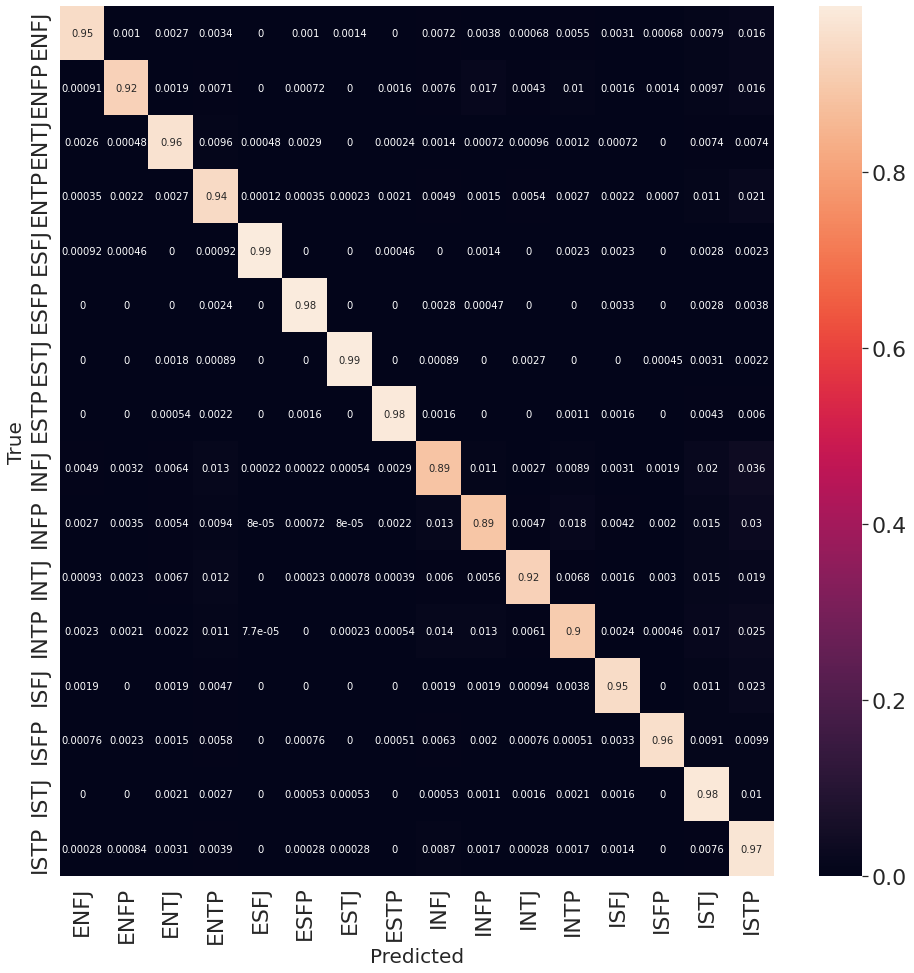

In [199]:
document_multimodel_run('mbti_t5_model',
                         model,
                         predicted_values,
                         actual_classes,
                         actual_values,
                         actual_classes )




# Error Analysis

In [142]:
test_df = test_df[['Username','Age','Posts','Occupation','message','combined']]
test_df.head()

,Username,Age,Posts,Occupation,message,combined
1400000,laurie,49.0,6072,nada,i liked it.,multilabel classification: laurie </s>49.0 </s...
1400001,searchingforpeace,52.0,5569,None,nope just why?,multilabel classification: searchingforpeace <...
1400002,anonymous,33.0,605,None,"heh, why n? he comes across as an enforcer o...",multilabel classification: anonymous </s>33.0 ...
1400003,eric b,56.0,3620,subway motorman,^ i think so too!! tyrion and brienne are both...,multilabel classification: eric b </s>56.0 </s...
1400004,yama,28.0,7684,microbiology technician,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,multilabel classification: yama </s>28.0 </s>7...


In [139]:
test_df.shape

(93106, 6)

In [137]:
df2.head()

,predicted,actual
0,ENFP,ENFP
1,ENFJ,ENFJ
2,INTP,INTP
3,INTP,INTP
4,ESFJ,ESFJ


In [145]:
test_df['predicted'] = df2['predicted'].to_list()

In [147]:
test_df['label'] = df2['actual'].to_list()

In [148]:
test_df.head()

,Username,Age,Posts,Occupation,message,combined,predicted,label
1400000,laurie,49.0,6072,nada,i liked it.,multilabel classification: laurie </s>49.0 </s...,ENFP,ENFP
1400001,searchingforpeace,52.0,5569,None,nope just why?,multilabel classification: searchingforpeace <...,ENFJ,ENFJ
1400002,anonymous,33.0,605,None,"heh, why n? he comes across as an enforcer o...",multilabel classification: anonymous </s>33.0 ...,INTP,INTP
1400003,eric b,56.0,3620,subway motorman,^ i think so too!! tyrion and brienne are both...,multilabel classification: eric b </s>56.0 </s...,INTP,INTP
1400004,yama,28.0,7684,microbiology technician,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,multilabel classification: yama </s>28.0 </s>7...,ESFJ,ESFJ


In [150]:
test_df['accurate'] = test_df['label'] == test_df['predicted']
test_df['message_len'] = test_df['message'].str.split().str.len()
test_df['feature_len'] = test_df['combined'].str.split().str.len()

In [151]:
test_df

,Username,Age,Posts,Occupation,message,combined,predicted,label,accurate,message_len,feature_len
1400000,laurie,49.0,6072,nada,i liked it.,multilabel classification: laurie </s>49.0 </s...,ENFP,ENFP,True,3,20
1400001,searchingforpeace,52.0,5569,None,nope just why?,multilabel classification: searchingforpeace <...,ENFJ,ENFJ,True,3,25
1400002,anonymous,33.0,605,None,"heh, why n? he comes across as an enforcer o...",multilabel classification: anonymous </s>33.0 ...,INTP,INTP,True,28,76
1400003,eric b,56.0,3620,subway motorman,^ i think so too!! tyrion and brienne are both...,multilabel classification: eric b </s>56.0 </s...,INTP,INTP,True,89,150
1400004,yama,28.0,7684,microbiology technician,[mentionYYYYYYYYYYYYYYY]forever[/mention] here...,multilabel classification: yama </s>28.0 </s>7...,ESFJ,ESFJ,True,4,28
...,...,...,...,...,...,...,...,...,...,...,...
1493101,coriolis,45.0,26905,None,"a lot of things because me feel guilty, even t...",multilabel classification: coriolis </s>45.0 <...,INTJ,INTJ,True,267,326
1493102,uumlau,56.0,5517,None,you are so cute. yes you can blow an extraor...,multilabel classification: uumlau </s>56.0 </s...,INTJ,INTJ,True,161,223
1493103,betty blue,45.0,5064,self employed,"vacuumed the whole house, ran greatest distanc...",multilabel classification: betty blue </s>45.0...,ENFP,ENFP,True,12,43
1493104,jeffster,46.0,6743,office manager for subway (eat fresh!),XXXXc ^?,multilabel classification: jeffster </s>46.0 <...,ESFP,ESFP,True,2,24


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


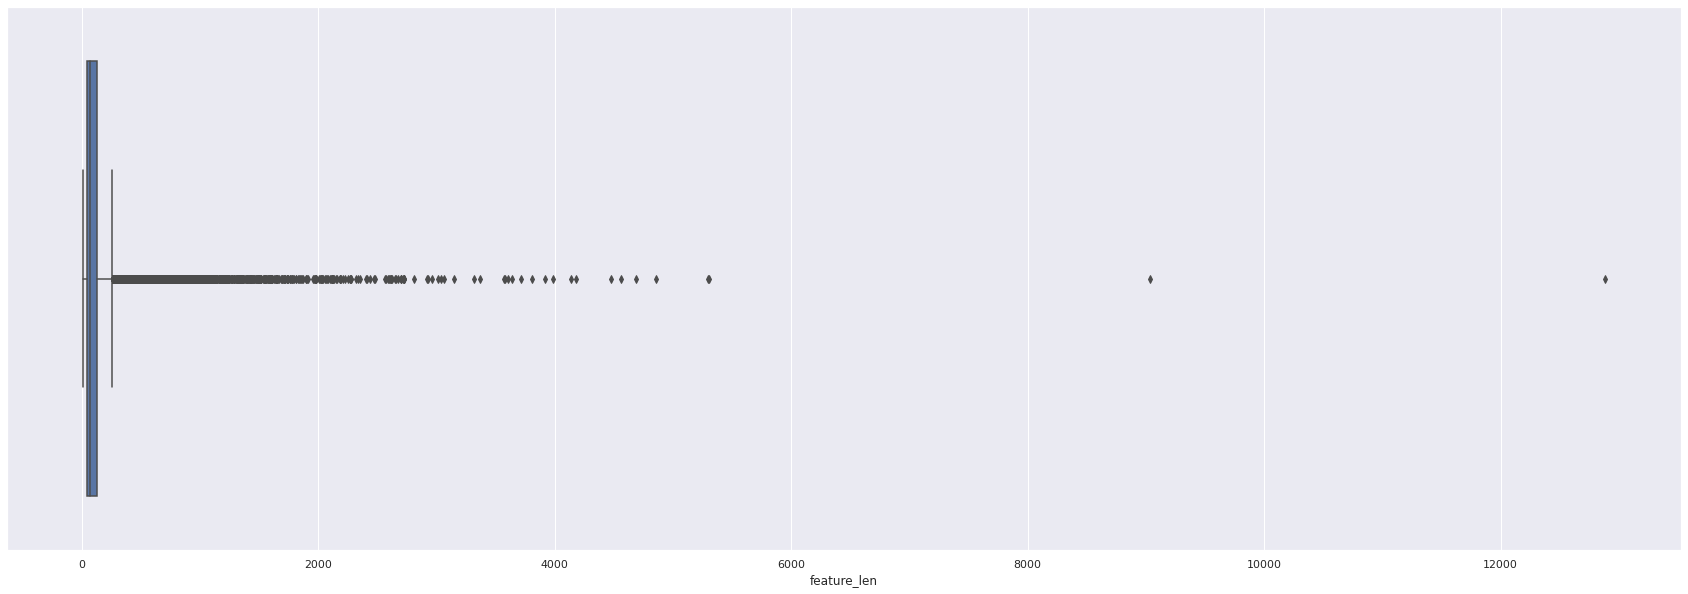

In [153]:
# get feature length distribution and look for outliers

sns.set(rc={'figure.figsize':(30,10)})
sns.boxplot(test_df['feature_len'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f730f540820>,
      dtype=object)

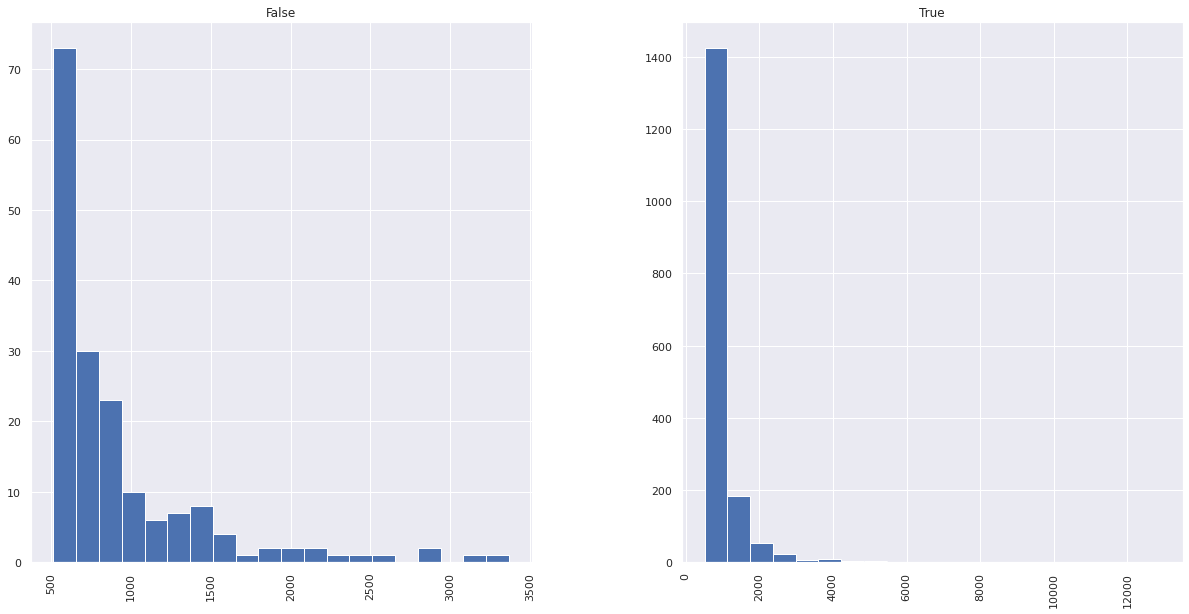

In [154]:
# T5 has a max length of 512, so features longer than that are truncated.  
# has does accuracy compare between truncated and non-truncated features?

test_df['feature_len'][test_df['feature_len'] > 512].hist(by=test_df['accurate'],bins=20,figsize=(20,10))

In [155]:

test_df['accurate'][test_df['feature_len'] > 512].value_counts(normalize = True)

True     0.907
False    0.093
Name: accurate, dtype: float64

In [156]:


test_df['accurate'][test_df['feature_len'] <= 512].value_counts(normalize = True)

True     0.926
False    0.074
Name: accurate, dtype: float64

# Comparing accuracy between truncated and non-truncated samples shows a small accuracy decline when the feature input is truncated.  However, our technique of extracting features and placing them at the beginning of hte feature input preserves information even when inputs are truncated.



Text(0, 0.5, 'Count')

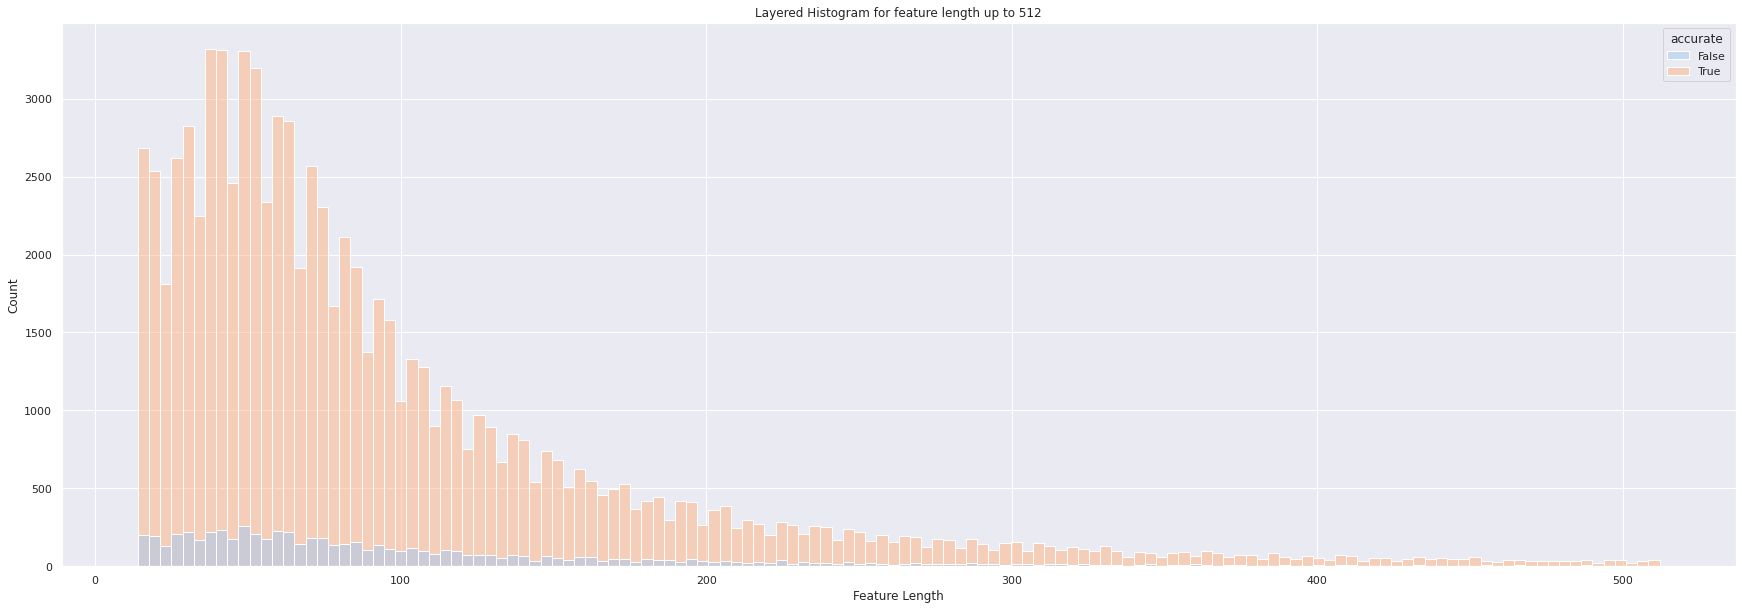

In [157]:

# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_df[test_df['feature_len'] <= 512], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for feature length up to 512")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")
     

Text(0, 0.5, 'Count')

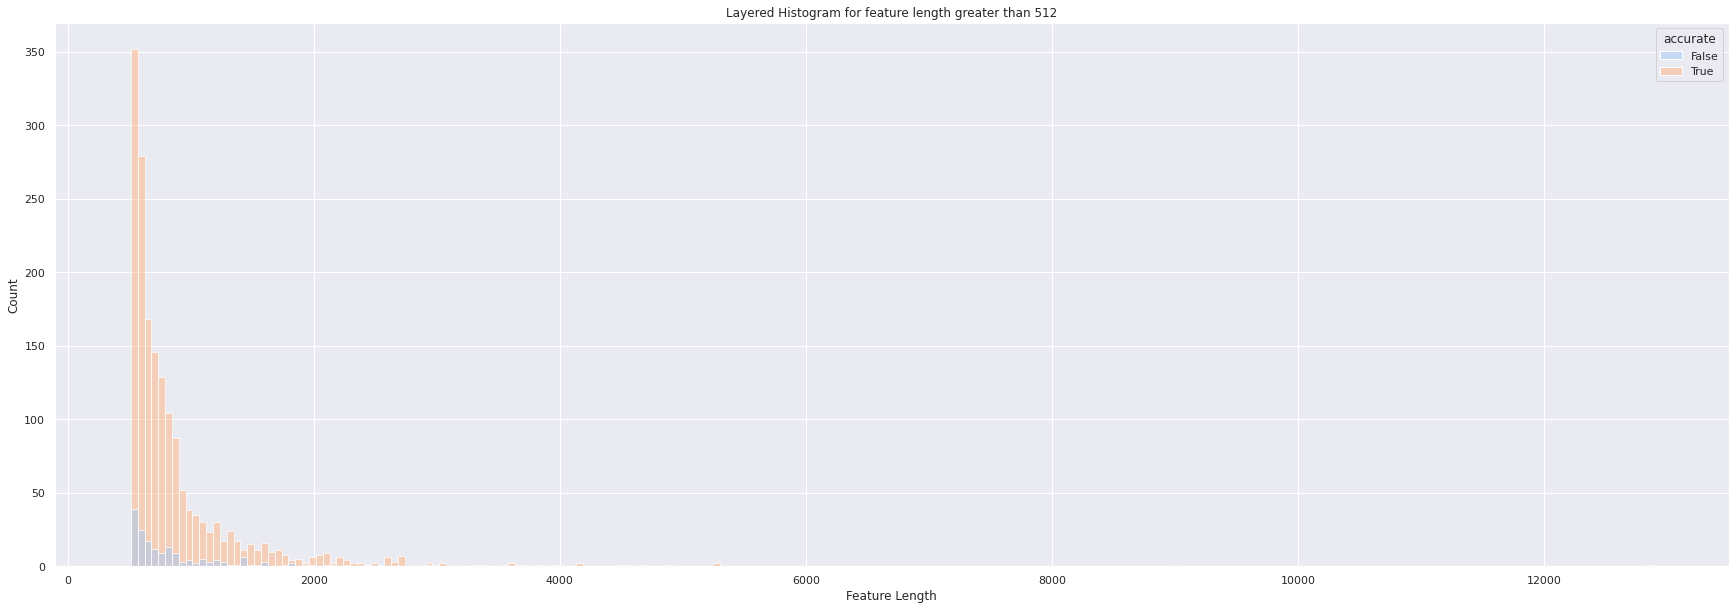

In [158]:

# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_df[test_df['feature_len'] > 512 ], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for feature length greater than 512")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")
     

# Next, look at relative accuracy across the 16 MBTI categories.


In [159]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center",fontsize=10) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left",fontsize=10)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
     

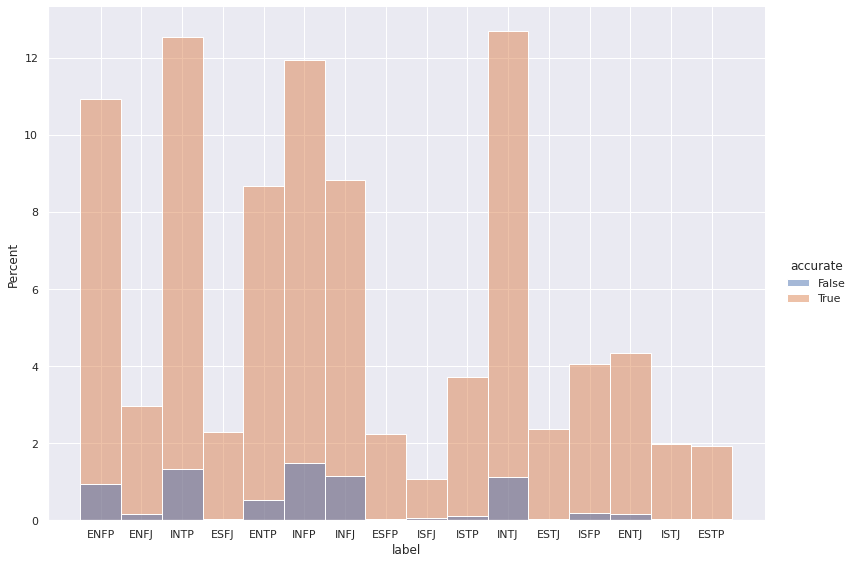

In [161]:

#let us look at percent distribution of errors per MBTI Type
sns.displot(data=test_df, x='label', stat='percent', hue='accurate',height=8, aspect=11/8)

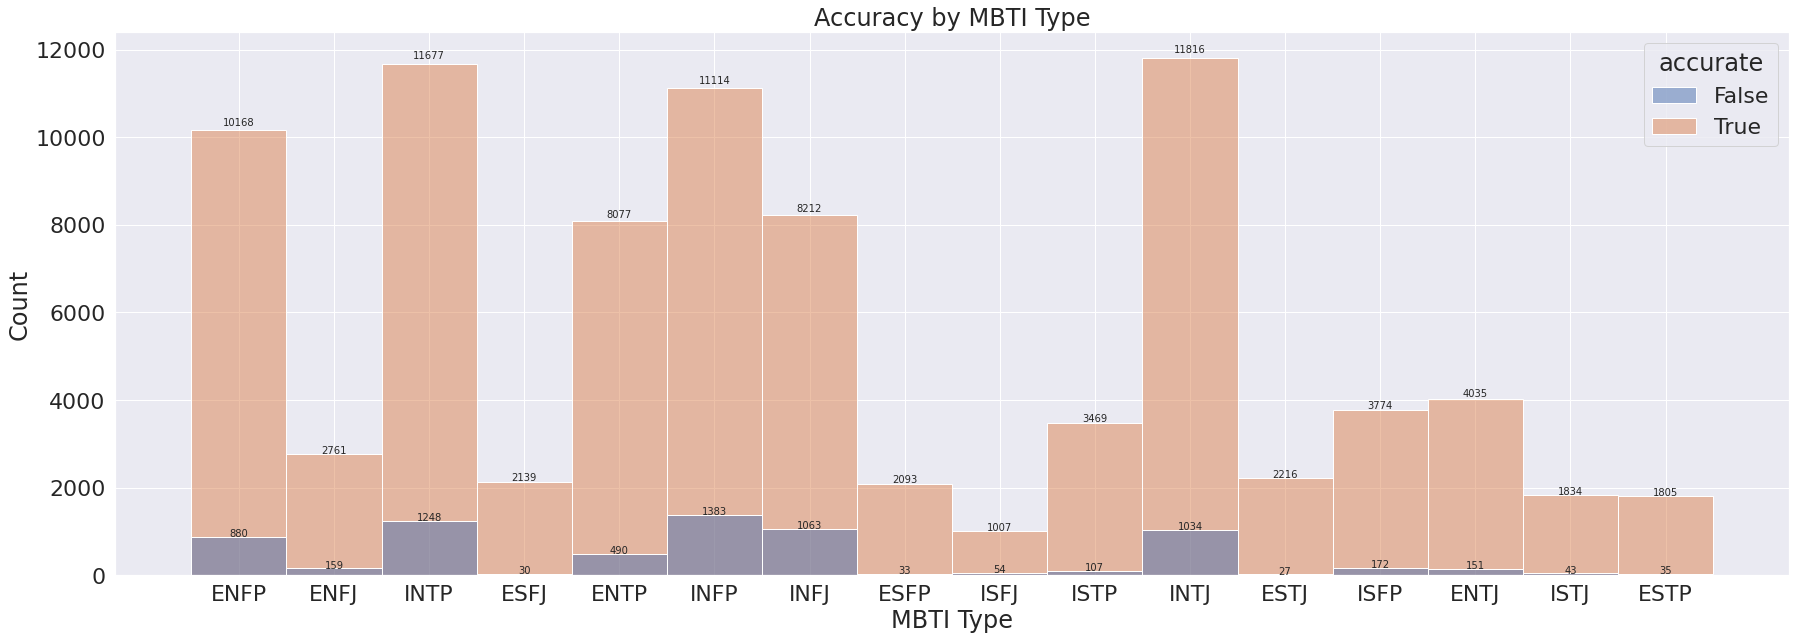

In [163]:

#plot with absolute count
f = plt.figure(figsize=(30,10))
sns.set(font_scale=2)
ax = f.add_subplot(1,1,1)
#sns.histplot(data=add_combined, x="MBTI Type", color="skyblue", label="accurate", kde=True,hue="accurate")
sns.histplot(data=test_df, x="label",  label="accurate", kde=False,hue="accurate")
#sns.histplot(data=add_combined, x="Posts", color="red", label="Posts", kde=True,hue="accurate")
ax.set_title("Accuracy by MBTI Type")
ax.set_xlabel("MBTI Type")
ax.set_ylabel("Count")
show_values(ax)
     

In [165]:


test_df.groupby(['label'])['accurate'].value_counts(normalize=True).unstack(level=1)

accurate,False,True
label,,
ENFJ,0.054,0.946
ENFP,0.080,0.920
ENTJ,0.036,0.964
ENTP,0.057,0.943
ESFJ,0.014,0.986
ESFP,0.016,0.984
ESTJ,0.012,0.988
ESTP,0.019,0.981
INFJ,0.115,0.885


In [166]:
top_5_worst = ['INFJ', 'INFP', 'INTP', 'INTJ', 'ENTP']

Text(0, 0.5, 'Count')

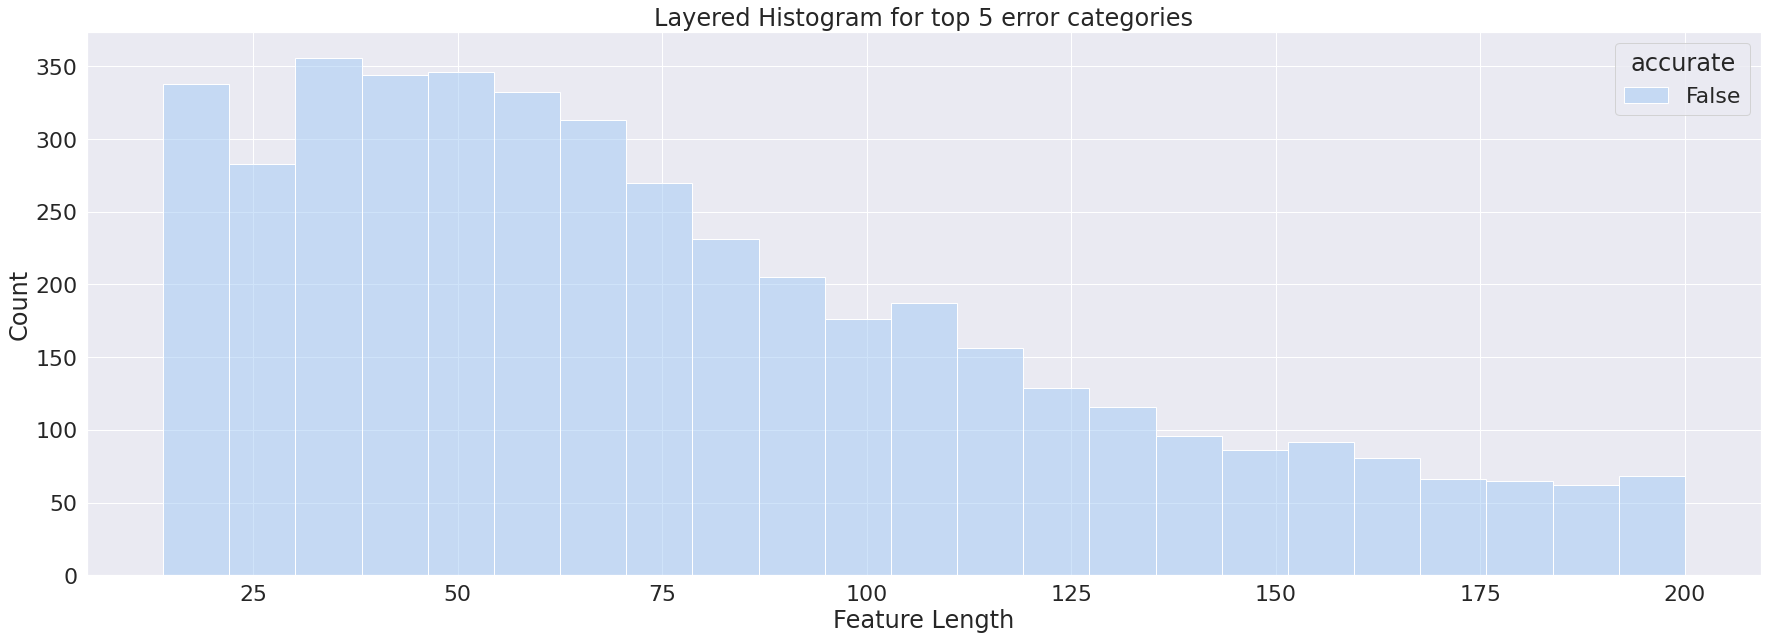

In [168]:
# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_df[(test_df['label'].isin(top_5_worst)) & (test_df['accurate'] == False) & (test_df['feature_len'] <= 200) ], ax=ax, stat="count", multiple="layer",
             x="feature_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for top 5 error categories")
ax.set_xlabel("Feature Length")
ax.set_ylabel("Count")
     


In [170]:

#let us create a error dataframe
drill_down = test_df[(test_df['label'].isin(top_5_worst)) & (test_df['accurate'] == False) & (test_df['feature_len'] <= 200) ]
     


In [171]:

#analyze occupations
drill_down['Occupation'].value_counts()

student                                                     348
professional artist                                          22
student-geology                                              21
enforcer. i am the law!                                      21
professional gimp, recovering attorney                       20
                                                           ... 
arcade clerk                                                  1
server                                                        1
communications                                                1
again with the jibes. memory loss is a serious condition      1
music student                                                 1
Name: Occupation, Length: 370, dtype: int64

In [172]:

drill_down['occu_len']=drill_down['Occupation'].str.split().str.len()

<ipython-input-172-b7e9c05b8fe7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drill_down['occu_len']=drill_down['Occupation'].str.split().str.len()


Text(0, 0.5, 'Count')

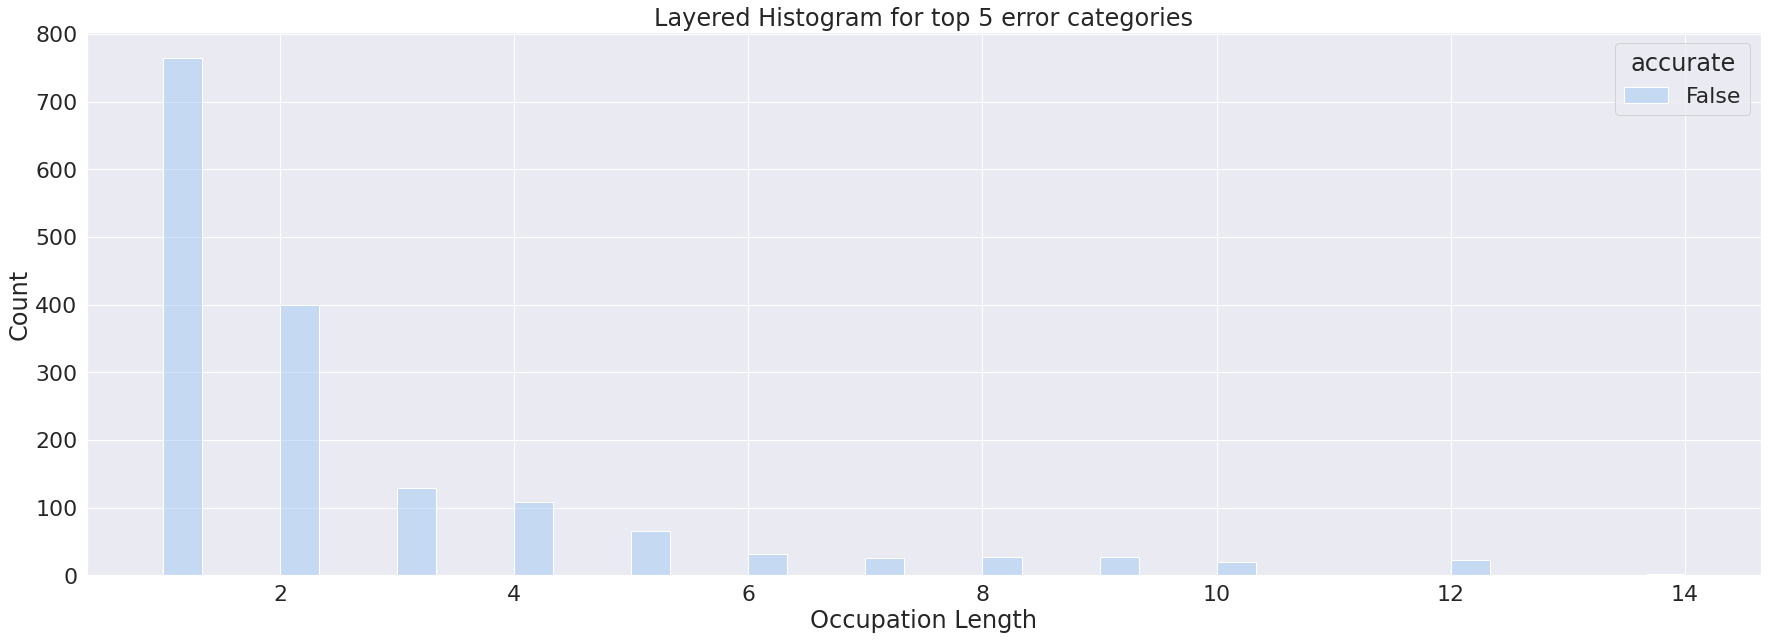

In [173]:

f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=drill_down, ax=ax, stat="count", multiple="layer",
             x="occu_len", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for top 5 error categories")
ax.set_xlabel("Occupation Length")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

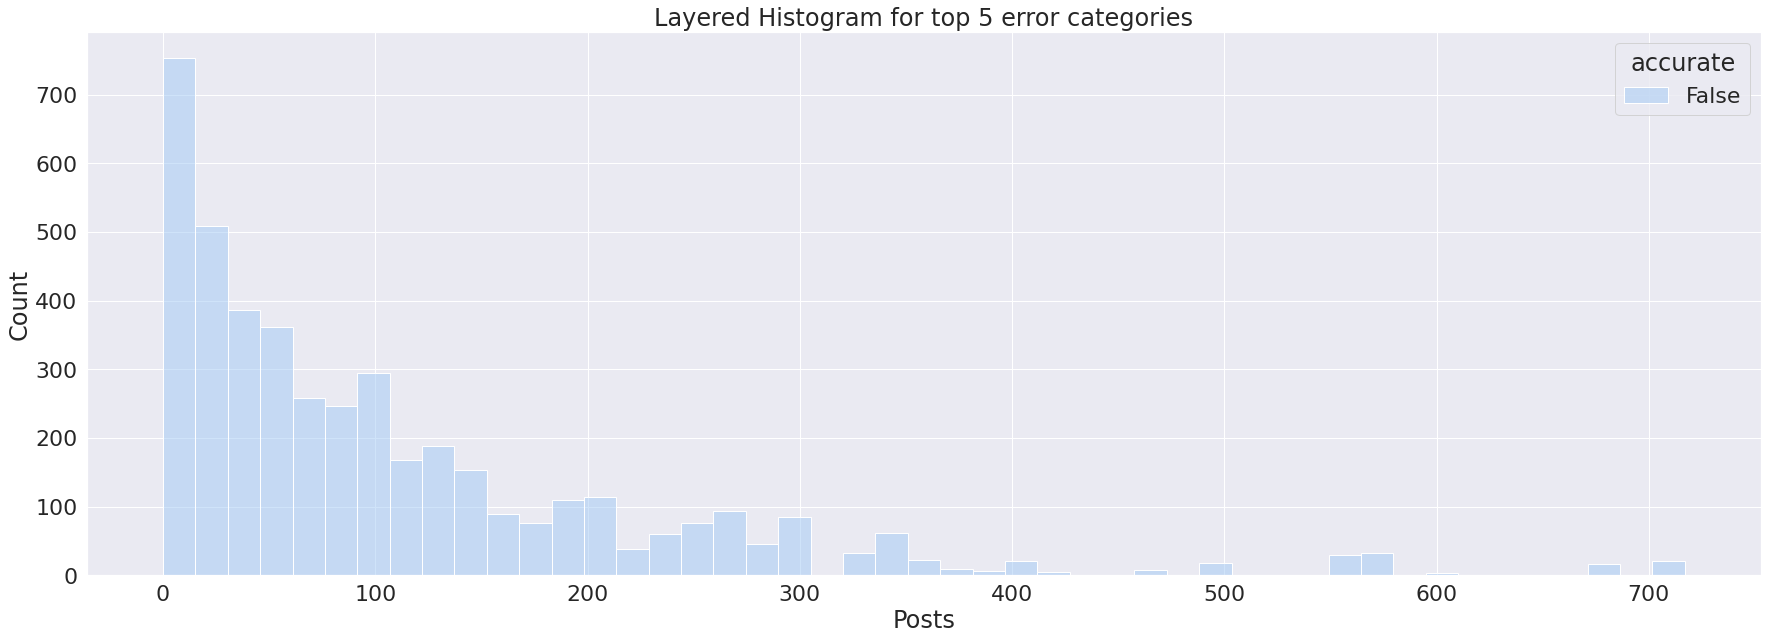

In [174]:

f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=drill_down, ax=ax, stat="count", multiple="layer",
             x="Posts", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for top 5 error categories")
ax.set_xlabel("Posts")
ax.set_ylabel("Count")

## This shows that the T5 model becomes more accurate for people who post more.  The greatest counts of misclassified types are for people with few posts.

In [175]:
drill_down[drill_down['occu_len']==2]

,Username,Age,Posts,Occupation,message,combined,predicted,label,accurate,message_len,feature_len,occu_len
1400146,evastover,23.0,77,freelance pianist,that is too freudian and slowmoving for my t...,multilabel classification: evastover </s>23.0 ...,ENTP,INFP,False,106,165,2.0
1400159,coll,43.0,73,mental masturbation,turnip farmer,multilabel classification: coll </s>43.0 </s>7...,ENTP,INFJ,False,2,16,2.0
1400400,observer84,38.0,44,lab rat,it is my understanding that there was no sex...,multilabel classification: observer84 </s>38.0...,ENFP,INTP,False,38,87,2.0
1400433,talisyn,38.0,84,elementary teacher,why? because he was actually never born.,multilabel classification: talisyn </s>38.0 </...,INFJ,INFP,False,7,31,2.0
1400550,sqnh,42.0,28,graduate student,someone get banned so i can read the banned an...,multilabel classification: sqnh </s>42.0 </s>2...,ISTJ,INFP,False,12,40,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1492326,peter pettishrooms,29.0,59,professional freeloader,cool thanks. glad to hear it. i actually wou...,multilabel classification: peter pettishrooms ...,ENFP,INTJ,False,29,73,2.0
1492387,moonlit_reveries,37.0,26,music student,hehe thanks for the welcome czecze. i hope to ...,multilabel classification: moonlit_reveries </...,ENFP,INFJ,False,14,58,2.0
1492515,snail,43.0,141,"artist, songwriter/performer",i like your writing as is. it could be a co...,multilabel classification: snail </s>43.0 </s>...,ISTJ,INFP,False,38,75,2.0
1492612,abhaya,38.0,97,tile setter/musician/artist,hello :hi:,multilabel classification: abhaya </s>38.0 </s...,ISTJ,INFP,False,2,18,2.0


Text(0, 0.5, 'Count')

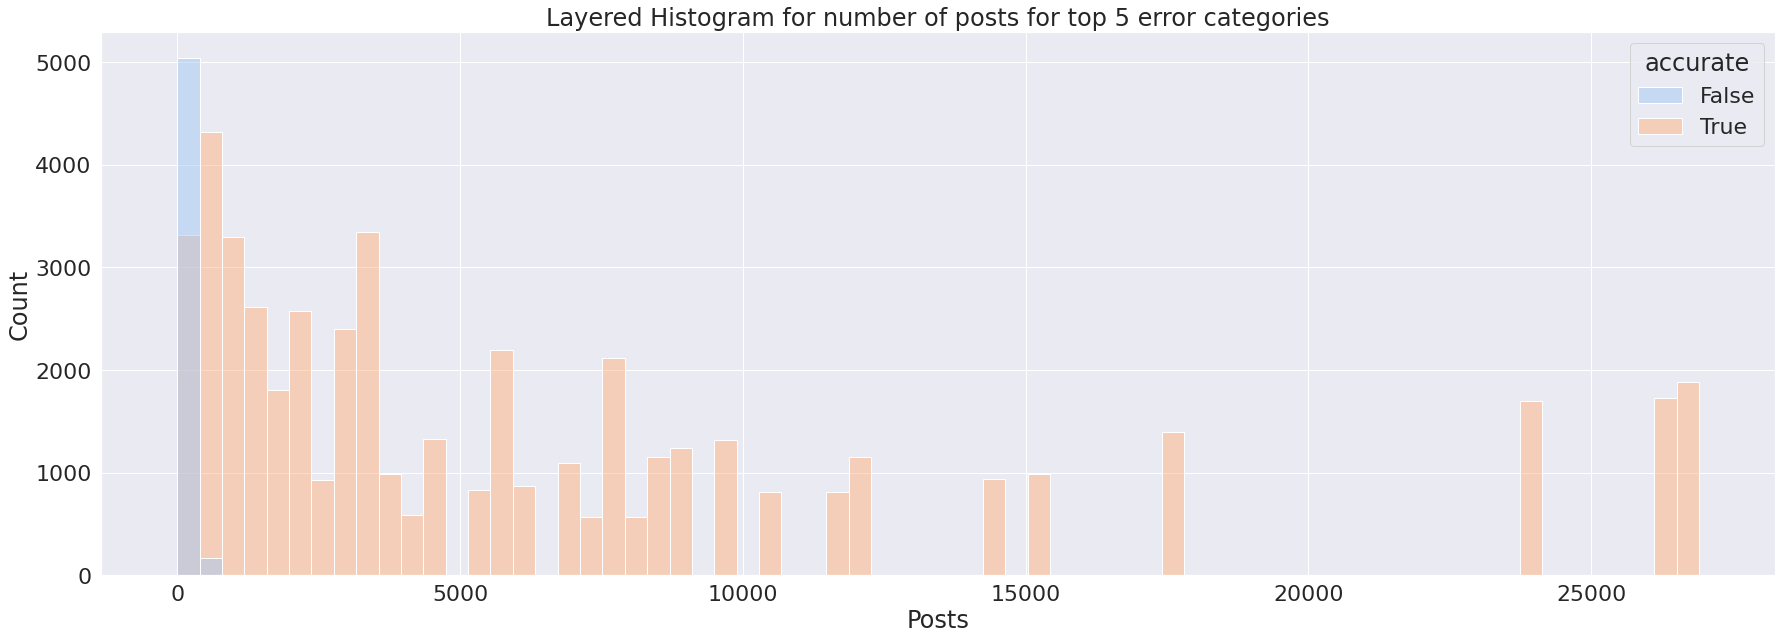

In [178]:

# layered histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(1,1,1)
import seaborn as sns
sns.histplot(data=test_df[test_df['label'].isin(top_5_worst)], ax=ax, stat="count", multiple="layer",
             x="Posts", kde=False,
             palette="pastel", hue="accurate",
             element="bars", legend=True)
ax.set_title("Layered Histogram for number of posts for top 5 error categories")
ax.set_xlabel("Posts")
ax.set_ylabel("Count")

## This plot shows again that we are prone to misclassifcation for users with few posts.